In [3]:
# === Шаг 1: Импорт необходимых библиотек ===
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import os # Добавим для удобной работы с путями

# === Шаг 2: Настройка и загрузка модели (делается один раз) ===

# Проверяем доступность CUDA и устанавливаем устройство
if torch.cuda.is_available():
    device = "cuda"
    print(f"CUDA доступна! Используем GPU: {torch.cuda.get_device_name(0)}")
else:
    device = "cpu"
    print("CUDA недоступна, используется CPU. Это будет медленно.")

# Пути к модели
model_checkpoint_path = "/app/MODELS/sam_vit_h_4b8939.pth"
model_type = "vit_h"

# Загружаем модель в память
print("\nЗагрузка модели Segment Anything...")
sam = sam_model_registry[model_type](checkpoint=model_checkpoint_path)
sam.to(device=device)
print("Модель успешно загружена.")

# Инициализируем генератор масок
mask_generator = SamAutomaticMaskGenerator(sam)
print("Генератор автоматических масок готов.")

🎉 CUDA доступна! Используем GPU: NVIDIA GeForce RTX 3080 Ti

Загрузка модели Segment Anything...
Модель успешно загружена.
Генератор автоматических масок готов.



--- Обработка изображения: 1_normals.jpg ---
Изображение успешно загружено. Размер: (2151, 5493, 3)
Запускаю сегментацию...
✅ Готово! Найдено 35 масок.

Подготовка визуализации...


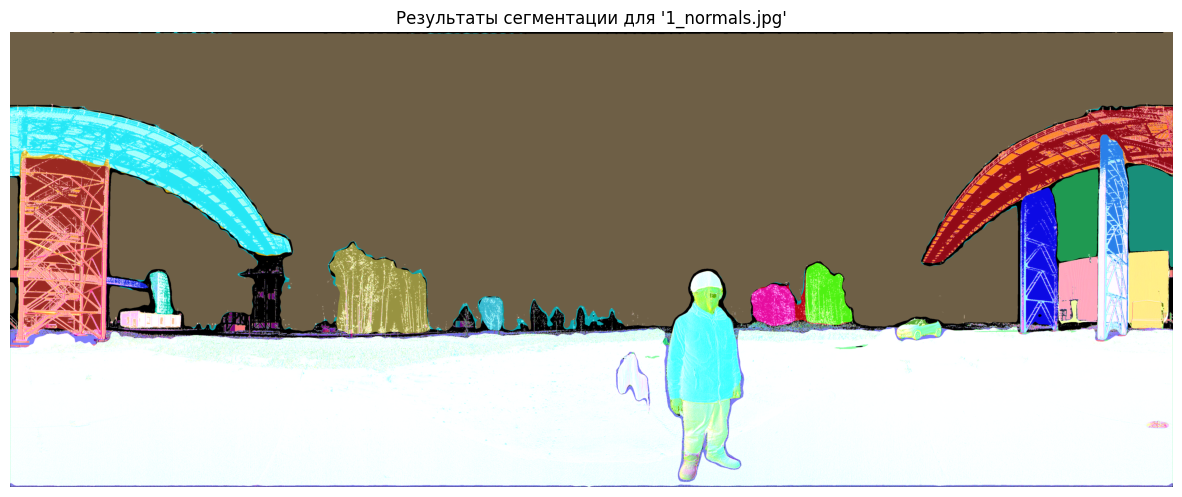

In [4]:
# === Шаг 3: Обработка вашего изображения ===

# Указываем путь к вашему файлу
image_path = "/app/CODE/Vistino20241014_E57/1_normals.jpg"
image_name = os.path.basename(image_path) # Получаем только имя файла для заголовков

print(f"\n--- Обработка изображения: {image_name} ---")

# Загружаем и обрабатываем изображение
try:
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise FileNotFoundError(f"Не удалось загрузить изображение. Проверьте путь: {image_path}")
        
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    print(f"Изображение успешно загружено. Размер: {image_rgb.shape}")

    # Запускаем сегментацию
    print("Запускаю сегментацию...")
    masks = mask_generator.generate(image_rgb)
    print(f"Готово! Найдено {len(masks)} масок.")

except FileNotFoundError as e:
    print(e)
    # Завершаем выполнение, если файл не найден
    masks = []


# === Шаг 4: Визуализация результатов ===

def show_anns_on_image(image_rgb, anns):
    """ Создает новое изображение, комбинируя исходное с масками. """
    if not anns: # Проверка, если список масок пуст
        print("Нет масок для отображения.")
        return image_rgb
    
    img = image_rgb.copy()
    overlay = np.zeros((img.shape[0], img.shape[1], 4), dtype=np.uint8)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.random.randint(0, 256, 3)
        overlay[m, :3] = color_mask
        overlay[m, 3] = 90

    img_rgba = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
    final_image = cv2.addWeighted(img_rgba, 1.0, overlay, 1.0, 0)
    final_image_rgb = cv2.cvtColor(final_image, cv2.COLOR_RGBA2RGB)
    return final_image_rgb

# Если маски были найдены, отображаем результат
if masks:
    print("\nПодготовка визуализации...")
    result_image = show_anns_on_image(image_rgb, masks)

    plt.figure(figsize=(15, 10))
    plt.imshow(result_image)
    plt.axis('off')
    plt.title(f"Результаты сегментации для '{image_name}'")
    plt.show()

In [5]:
# Посмотрим, сколько всего масок (мы уже знаем, что 35)
print(f"Всего масок: {len(masks)}")

# Посмотрим, какие ключи (какая информация) есть для каждой маски
# Возьмем первую маску в качестве примера (индекс 0)
if len(masks) > 0:
    print("\nКлючи для одной маски:")
    print(list(masks[0].keys()))

Всего масок: 35

Ключи для одной маски:
['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box']


Исследуем маску с индексом 20
Ее площадь: 60869 пикселей
Ее рамка (bbox): [3163, 1735, 280, 380]


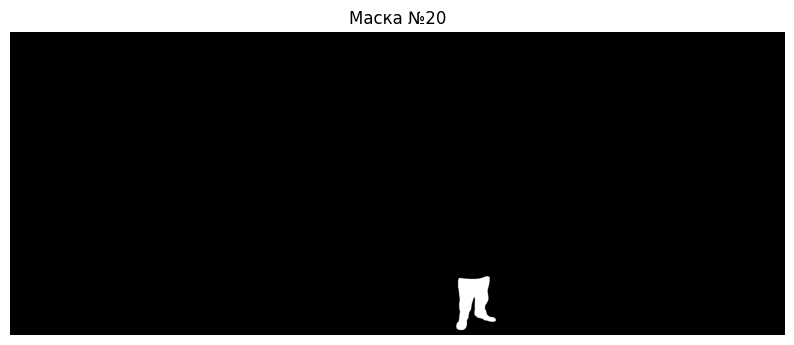

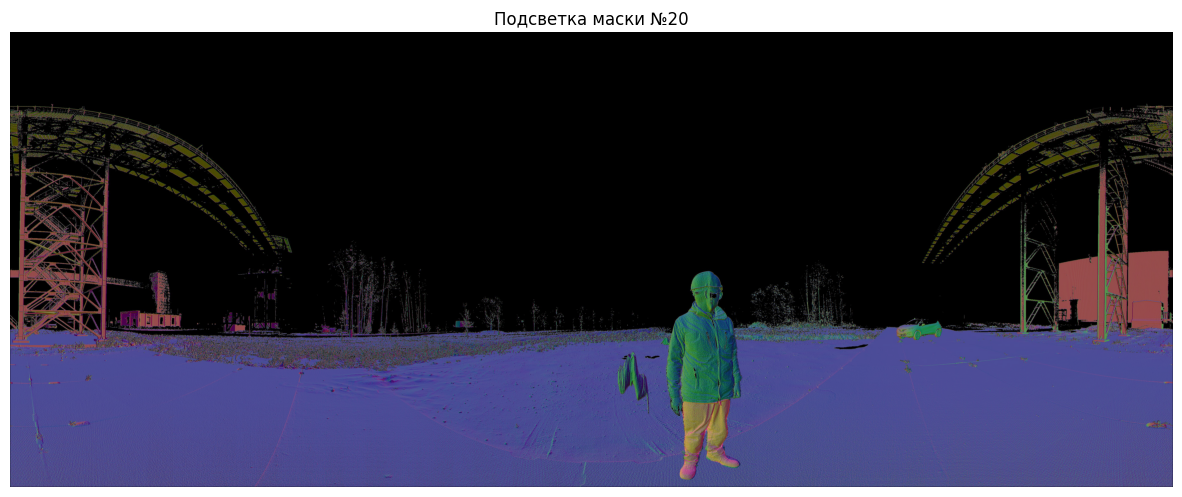

In [8]:
### Визуализируем одну конкретную маску

# --- ВЫБЕРИТЕ ИНДЕКС МАСКИ ДЛЯ ИССЛЕДОВАНИЯ ---
mask_index = 20  # Попробуйте менять это число от 0 до 34

# Получаем данные для выбранной маски
single_mask_data = masks[mask_index]

# Извлекаем саму маску (2D массив True/False)
mask = single_mask_data['segmentation']

# Извлекаем ее площадь и рамку
area = single_mask_data['area']
bbox = single_mask_data['bbox']

print(f"Исследуем маску с индексом {mask_index}")
print(f"Ее площадь: {area} пикселей")
print(f"Ее рамка (bbox): {bbox}")

# Рисуем только эту маску
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray') # cmap='gray' покажет ее в черно-белом виде
plt.axis('off')
plt.title(f"Маска №{mask_index}")
plt.show()

###  Накладываем одну маску на исходное изображение
# Используем ту же выбранную маску из ячейки выше

# Создаем цветную версию маски (например, ярко-красную)
highlight_color = [255, 0, 0] # Красный
highlight_mask = np.zeros_like(image_rgb)
highlight_mask[mask] = highlight_color

# Смешиваем исходное изображение с нашей подсветкой
# 0.6 и 0.4 - коэффициенты прозрачности
highlighted_image = cv2.addWeighted(image_rgb, 0.6, highlight_mask, 0.4, 0)

plt.figure(figsize=(15, 10))
plt.imshow(highlighted_image)
plt.axis('off')
plt.title(f"Подсветка маски №{mask_index}")
plt.show()